# VR-Model-Size

**Motivation:** For the pflow studies, the architecture size was the most relevant hyperparameter of the ones that I tried out. So for the studies with the new hybrid that has the 125 GeV (l + c) jet $p_T$ cut, I want to see if increasing the model size helps in terms of the solution that we converge to.

Michael suggested that I look at this instead of just recycling the same hyperparameters from the old hybrid b/c the VR jet spectrum has *more variance* than the calo jet $p_T$ spectrum, so this increased variance might require a more complicated model to learn an optimal decision boundary.

Just as a quick reminder, the correlation between the VR and pflow jet $p_T$s on $t\bar{t}$ is shown below.

<img src="../../figures/mc16d_VR_ttbar/PFlow_cf/jet_pt_2d_scatter.pdf" width="400">

Studies from April 2019


In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
jetCollection = 'VR'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"

nFeatures=13
figDir = '../../figures/'

In [3]:
trJetCol = 'VR'
trainPhysicsSample = 'hybrid_1.5TeV_cut_125GeV'
Ntrain = 3000000
nTrks_tr = 15

**New for this week's studes**

We noticed that the hybrid sample from Francesco *didn't* have $\tau$s inside, so I trained these new hybrid models w/o a $\tau$ output node to account for this. So I'll just need to remove the taus from the $t\bar{}$


Evaluating on ttbar
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


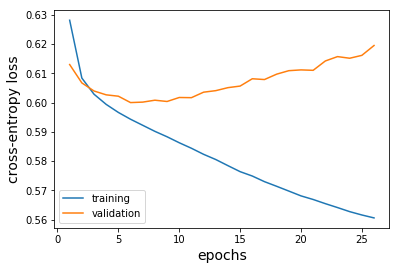

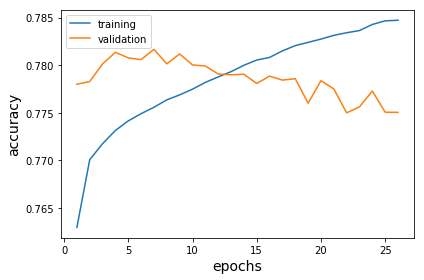

Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


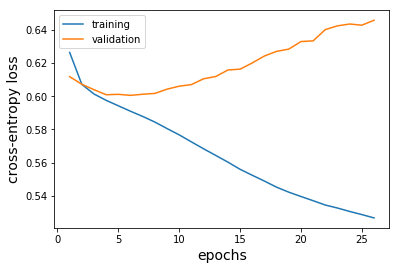

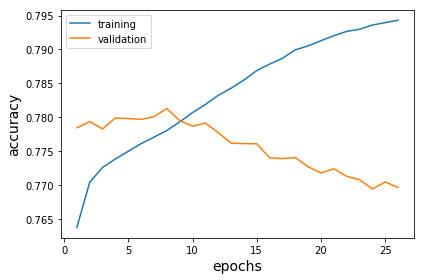

Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


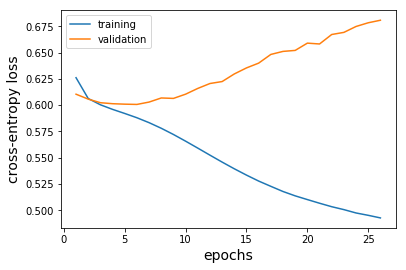

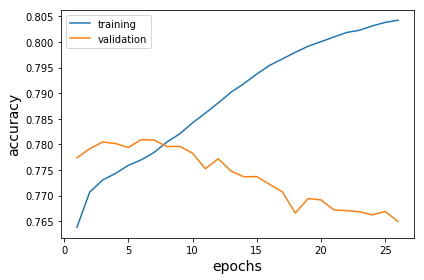

Load in the previously saved efficiency file
Evaluating on Zprime_1.5TeV
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Evaluating on Zprime_1.5TeV_2lead
Initialize method from myModel()
Loading previously trained LSTM
min: -6.43, max: 12.82


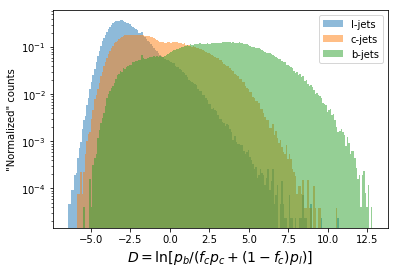

Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
min: -7.97, max: 12.94


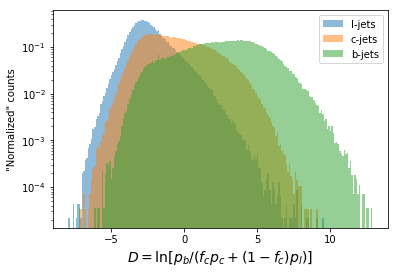

In [4]:
leffs, ceffs, beffs, = [],[],[]
discs, labels = [],[]
ys, pts, etas = [],[],[]

for physicsSample, nTrks_te, miniJetTag in \
    zip(['ttbar','Zprime_1.5TeV','Zprime_1.5TeV_2lead'],
        [15,25,25],['2m','2m','1000k']):
        
    print('Evaluating on '+physicsSample)
        
    for nHidden in [200,300,400]:
        
        # Load in the sample for evaluation
        subDir = 'mc16d_{}_{}'.format(jetCollection,physicsSample)
        dataDir = '../../data/'+subDir
        scale_tag = "_{}_scale".format(trainPhysicsSample) if physicsSample != trainPhysicsSample else ""
        if trJetCol != jetCollection:
            scale_tag = '_' + trJetCol + scale_tag

        dataTagTest = "{}test_{}trks_{}_sd0_rev{}".format(miniJetTag,nTrks_te,vStr, scale_tag)

        f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
        f = h5py.File(f_name,"r")

        X = f['X_test'][:]
        y = f['y_test'][:]
        ix = f['ix_test'][:]

        f.close()

        # Only keep the events without taus, since these models were only trained w/ 
        # 3 output classes
        notaus = (y != 3)
        X  = X[notaus]
        y  = y[notaus]
        ix = ix[notaus]
          
        # If we're evaluating the model that has been trained on 
        nTest = X.shape[0]
        if nTrks_te > nTrks_tr:
            # Restrict the # of tracks you're evaluating with
            X = X[:,:nTrks_tr,:]
        if nTrks_te < nTrks_tr:
            # Append 0s
            zeros = np.zeros((nTest,nTrks_tr-nTrks_te,nFeatures))
            X = np.concatenate((X,zeros),axis=1)

        # Also open the df so that you'll have access to the jet pt and eta
        df_tag = '{}test_{}trks_sd0_rev'.format(miniJetTag,nTrks_te)
        jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')

        # Load in the model
        modelDir = "../../models/mc16d_{}_{}".format(trJetCol,trainPhysicsSample)
        dataTagTrain = "{}train_{}trks_{}_sd0_rev".format(nJetsTag(Ntrain),nTrks_tr,vStr)
        m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, 
                   dataTag=dataTagTrain, loadModel=True, nClasses=3)

        # Training metrics
        if physicsSample == 'ttbar':
            trainingMetrics(m.modelName,modelDir=modelDir)

        # Get the efficiencies
        tag = '_eval_{}'.format(physicsSample) if physicsSample != trainPhysicsSample else ''
        (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True,
                                          figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)

        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)

        discs.append(d)
        labels.append('train {}, eval {}'.format(trainPhysicsSample,physicsSample))

        ys.append(y)
        pts.append(jet_df.pt.values)
        etas.append(jet_df.eta.values)


## $t\bar{t}$ evaluation

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
../../plottingFcts.py:608: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


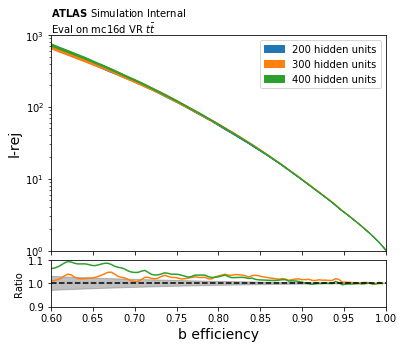

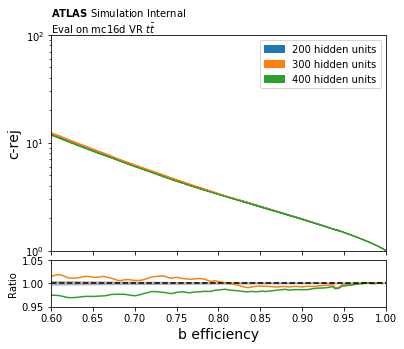

In [7]:
train_labels = ["{} hidden units".format(nHidden) for nHidden in [200,300,400]]
ntests = [np.sum(ys[0]==label) for label in range(3) ]

subDir = 'mc16d_VR_ttbar'
plotTag = 'rej_nHidden_newHybrid'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR $t\bar{t}$"

colors = ['C0','C1','C2']

plotROCRatio(beffs[:3], leffs[:3], 
             train_labels, rrange=(.9,1.1),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio(beffs[:3], ceffs[:3], 
             train_labels, rrange=(.95,1.05),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)

## Z' evaluation

For now, I'm looking at the inclusive Z' sample, so all of the jets in the event, since this is also what I was training the hybrid on.

../../plottingFcts.py:608: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


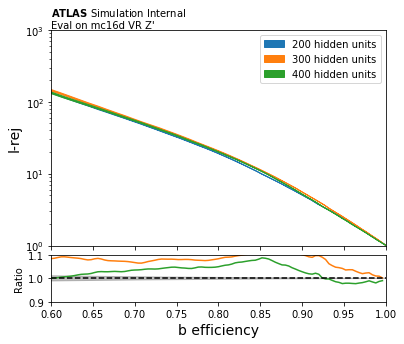

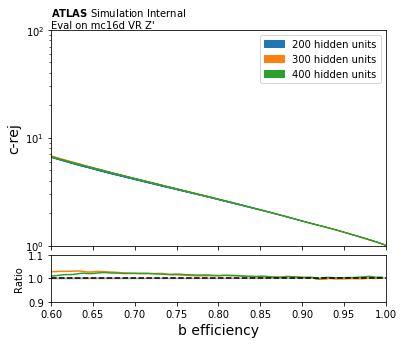

In [8]:
ntests = [np.sum(ys[3]==label) for label in range(3) ]

subDir = 'mc16d_VR_Zprime_1.5TeV'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR Z'"

plotROCRatio(beffs[3:6], leffs[3:6], 
             train_labels, rrange=(.9,1.1),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio(beffs[3:6], ceffs[3:6], 
             train_labels, rrange=(.9,1.1),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)

## Z' evaluation with the two leading jets

I'm hoping that these plots will tell the same story as the other ones, but I think it's a good thing to sanity check too :)

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


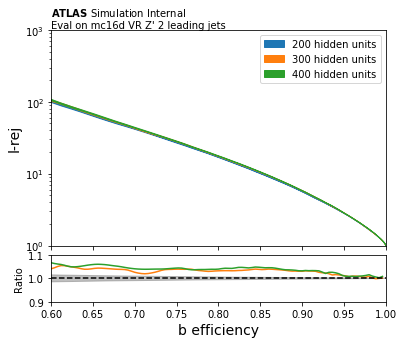

../../plottingFcts.py:608: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)


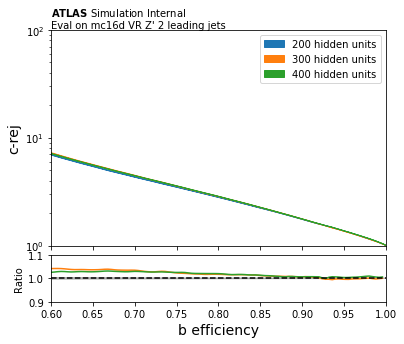

In [9]:
ntests = [np.sum(ys[6]==label) for label in range(3) ]

subDir = 'mc16d_VR_Zprime_1.5TeV_2lead'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR Z' 2 leading jets"

plotROCRatio(beffs[6:], leffs[6:], 
             train_labels, rrange=(.9,1.1),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio(beffs[6:], ceffs[6:], 
             train_labels, rrange=(.9,1.1),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)